## Introduction

This notebook tries to show how you can perform more than 82% of accuracy on the Titanic dataset with XGBoost and only five features. Everything is explained step by step.

Note that this introduction explains basically everything you need to know. Once you read it, you will be able to do your own work to reach 82%. So don't skip it :)

**Warning**: Some of technics exposed here can be considered as data leakage. So if it's your first machine learning experience, maybe you don't want to start with the method exposed here. This notebook shows how you can reach the top leaderboard in the context of a Kaggle competition, not how to write the best model for a production environment.

First of all, I want to thank [Chris Deotte](https://www.kaggle.com/cdeotte) for all his amazing work about the Titanic competition and especially for his "[Woman Child Group model](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook)" which highly inspires my kernel. Without his work, I couldn't have done this notebook.

And I want to thank [Tae Hyon Whang](https://www.kaggle.com/numbersareuseful) for his work [here](https://www.kaggle.com/numbersareuseful/titanic-starter-with-xgboost-173-209-lb/notebook) which helped me perform a best gridsearch for my XGBoost hyper-parameters.

### A bit of context

When I decided to try to make a good score on the Titanic competition, my first thought was: All I need is:

1. First, let's say a pretty "classical and strong" feature engineering: clean all data, impute empty values, extract all informations like name title, cabin letter and so on.

2. And then, perform an effective gridsearch to find the best hyper-parameters for XGBoost.

But... I was kind of wrong. I tried A LOT of stuffs following this direction. But nothing really worked. I tried to make the best model to impute empty values, like fill empty ages with XGBoost, I tried a lot of combinations between features. But my best score was stuck to around 0.78%, maybe 0.79%. I didn't understand why I couldn't reach 0.80%, which was basically my goal.

So I started to dig in the top kernels. To be honest, I saw a lot of kernels which were supposed to be good, but which weren't. And I noticed that the best kernels in this competition are not always the most famous ones.

Anyway, let's try to explain what are the keys of the success for this competition.

### Avoid overfitting

The first problem with the Titanic dataset is overfitting. At first it seems like each feature is giving you a lot of new insights. But the more I digged, the more I realized the information was **highly redondant**. And since we don't have a lot of observations, we have to be careful about it.

### About gender and children

First of all, never forget one thing: The simple gender model where you predict all women survived and all men died reachs a leaderboard score more than 76%.

So, yes: your fate on the Titanic was highly correlated with your gender: if you're a man, you'll probably die. If you're a woman, you'll probably survive.

We can also say that if you're a boy, you'll probably survive too. Because "Women and Children First!" was true.

So if you want to do a better job than this very simple model, you have to try to predict some women and children that died. And try to predict some men who survived (this is the most difficult).

### Money, money, money

At first, I was persuaded that if you just add "money features" like "PClass" and "Ticket Fare" (in addition to gender), this will help a lot. Actually, it could help. But as we'll see, the class influences the fate of the entire family, more than each individual passenger.

And as you'll see, I don't use any "money feature" in this model.

### How old are you?

The age is not that useful that I thought too. Because, basically: if you're a woman, you'll survive, either you're young or old. If you're a man, you'll survive if you're under 16. But since there are a lot of missing values, it's better to use the "Master" title which is filled for everybody!

So we won't use the Age feature in this model.

### It's all about group!

XGBoost can find a lot of connexions, even subtle and complex connexions. That's why it works pretty well. But, you still have to help it with a good feature engineering. So here is the real key of the success:

For this competition, a good feature ingineering implies realizing that passengers can form **groups**! Without it, you won't be able to reach 0.80%. The groups can be formed by a same surname or a same ticket.

But your model can't discover it by itself. You have to do something. The natural way to do it would be: extracting names (and / or tickets) and dummify it. Et voilà ! Now your model knows how to connect passengers to each other. But... no. The dataset is too short to do this. On the boat, you don't have four or five families. You have hundreds. So It will be too much groups, too much features.

So, the only way is to identify groups and after that you have to find a way to attribute one or several scores to your groups which will be your new features(s). And once again, you will have to choose a good way to do it, because you don't want to overfit.

### Woman Child Groups

I choosed the "woman child group" approach formalized by Chris Deotte. And then I combined name groups with ticket groups. And finally, thanks to XGBoost, I used a pretty convenient feature of this algorithm: you can feed it with empty data. So your dummy variables can actually take three different values.

Basically, the idea is: all families died or survived together. When we say "family", we think about "women and children". Because, yes, if you're a man, you probably died anyway.

So, the idea is to analyze WC groups and try to score them.

1. If all women and children survived, we will notice it. (New feature equals 1)
2. If they all died, we'll also notice it. (Another new feature equals 1)
3. Sometimes we'll be able to say "it's neither one nor the other. It's a mixed group". (Both features equal 0)
4. And sometimes, we can't say anything, so we'll say nothing: for this, thanks to XGBoost which can take into account empty values.

So, as we can see with this model: a majority of the information to predict passengers fate is concentred in:

1. Your gender
2. The rest of your group

And of course some features probably influence your group's fate. But this model doesn't event use PClass or Ticket price.

You're a man? You probably died, either you're rich or not. You're a child or a woman? Let's have a look at what happened to your family and I'll tell if you survived or not.

So, at the end, the dataset is composed of five features:

1. Are you a woman?
2. Are you boy?
3. Family size
4. Are you in a woman-child group? Did all they survive?
5. Are you in a woman-child group? Did all they die?

OK, I wrote enough :) Let's have a look at the code!

## Import librairies & data

### Librairies

In [ ]:
# Standard library
import pickle
import warnings

# Data analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Modelization
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

### Data

In [ ]:
# Files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
training_set = pd.read_csv("/kaggle/input/titanic/train.csv")
test_set = pd.read_csv("/kaggle/input/titanic/test.csv")

### Settings

Just some display settings.

In [ ]:
sns.set(style="whitegrid")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
warnings.filterwarnings('ignore')

## Functions

Don't look at them now. Jump directly to the next. You'll come back when I use it.

In [ ]:
def cat_analysis(df, feature, x, y, figsize=(8,5), rotation="45", palette=None, order=None):
    
    data = (pd.DataFrame(df[feature].value_counts())
                .reset_index()
                .rename(columns={'index': x, feature: y}))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=x, y=y, data=data, palette=palette, order=order);
    plt.xticks(rotation=rotation)
    plt.title(f"Distribution of {feature}")
    plt.show()
    
def dummify(data, feature):
    
    # Get dummy variables
    temp_df = pd.get_dummies(data[feature])
    
    # Add prefix to prevent duplicated feature names
    temp_df = temp_df.add_prefix(feature + "_")
    
    # Concatenante the new features with the main dataframe
    data = pd.concat([data, temp_df], axis=1)
    
    # Drop the original feature
    data.drop(feature, axis=1, inplace=True)
    
    # Return the new dataframe
    return data

def prepare_data(data_original):
    """ Prepare the data for the Titanic Competition. """
    
    data = data_original.copy()
    
    ################ Name => Boy / surname ######################
    
    # From the name, extract "is a boy?" and "surname"
    data["boy"] = data["Name"].apply(lambda x: 1 if ("Master." in x.split(" ")[1:-1]) else 0)
    data["surname"] = data["Name"].apply(lambda x: x.split(",")[0])
    data.drop("Name", axis=1, inplace=True)
    
    # Sex
    data = dummify(data, "Sex")
    # Since "Sex" it's a binary variable, we don't need to keep a feature for male AND for female
    data.drop("Sex_male", axis=1, inplace=True) # Just one is enough
    
    ################## Ticket ##########################
    data["wcg_ticket"] = data["Ticket"].copy()
    mask = (data["Sex_female"] == 0) & (data["boy"] == 0)
    data.loc[mask, "wcg_ticket"] = "no_group"
    data.drop("Ticket", axis=1, inplace=True)
    
    ################## Cabin ######################
    data.drop("Cabin", axis=1, inplace=True) # And finally, drop the original column
    
    ################ Embarked ###################
    data.drop("Embarked", axis=1, inplace=True)
    
    ############### Family Size ################
    data["family_size"] = 1 + data["SibSp"] + data["Parch"]
    data.drop(["SibSp", "Parch"], axis=1, inplace=True)
    
    ############## PassengerId #################
    data.drop("PassengerId", axis=1, inplace=True)
    
    ############## Fare ########################
    data.drop("Fare", axis=1, inplace=True)
    
    ############## Age #########################
    data.drop("Age", axis=1, inplace=True)
    
    ############## PClass ######################
    data.drop("Pclass", axis=1, inplace=True)
    
    ############# Woman Child Group ############
    
    # Copy family name to create a "woman child group" based on the surname
    data["wcg_surname"] = data["surname"].copy()

    # Remove men from groups
    mask = (data["Sex_female"] == 0) & (data["boy"] == 0)
    data.loc[mask, "wcg_surname"] = "no_group"
    
    data.drop("surname", axis=1, inplace=True)
    
    return data

In [ ]:
def my_xgb(data, target, params):
    
    # Create X and y
    X = data.drop(target, axis=1)
    y = data[target]
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    # Create a XGBoost classifier (scikit-learn API wrapper)
    xgb_clf = xgb.XGBClassifier()
    
    # Perform a gridsearch with sklearn
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    gridsearch = GridSearchCV(xgb_clf, param_grid=params, scoring="accuracy", cv=kf, return_train_score=True)
    gridsearch.fit(X_scaled, y)
    
    # Return the gridsearch results plus the scaler
    return gridsearch, scaler

## Data overview

#### Training set

In [ ]:
print(training_set.shape)
display(training_set.head())

#### Test set

In [ ]:
print(test_set.shape)
display(test_set.head())

### NaN by feature

The first thing I do when I load a dataset is to have a look at empty values by column.

In [ ]:
nanbyfeature = pd.DataFrame(training_set.isna().sum()).sort_values(by=0, ascending=False)
nanbyfeature["percent"] = np.round(nanbyfeature[0] / len(training_set) * 100,2)
nanbyfeature

As we can see, "Cabin" and "Age" have a lot of empty values. But for this kernel we don't care since I won't use them :)

## Feature engineering

### Survived

Let's quickly analyze our target first to see how is balanced the training dataset.

In [ ]:
survived_passengers = training_set["Survived"].sum() / len(training_set)
died_passengers = 1 - survived_passengers
print(f"Survived passengers: {survived_passengers:.2%}")
print(f"Died passengers: {died_passengers:.2%}")

It's pretty well balanced. But we can notice that we still have some more died passengers than survived ones. So in order to improve our accuracy score, it will still easier to find the ones who died than survived.

### Survived by gender

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="Sex", y="Survived", data=training_set);
plt.xticks(rotation=0)
plt.title("Percentage of survived by gender")
plt.show()

Now we see why the Gender Model is a good one.

### Survived by Gender + Pclass

As I said, I didn't use the "Pclass" feature in my model. Let's have a look though.

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="Sex", y="Survived", data=training_set, hue="Pclass");
plt.xticks(rotation=0)
plt.title("Percentage of survived by gender")
plt.show()

Yes, your class obviously influences your fate. But the most important thing is:

1. If you're a rich man, you will still probably die
2. If you're a woman, even a "poor" one, it's basically 50/50.

So this feature doesn't really help by itself. Of course there are maybe some more complex interractions with other features. But the point is: if your starting point is the gender model (which seems not a bad idead), adding Pclass feature won't bring a new useful information.

### Family size (new feature)

Our model is based on groups, right? So to complete informations about groups, let's feed our model with each family's size.

Let's create a new feature "family size". Basically, it's a linear combination of SibSp and Parch where the intercept equals one, representing the passenger themself. So we have :

> *family_size* = 1 + 1*SibSp* + 1*Parch*

Note: I didn't use Name or Ticket to create this feature, but maybe it could be a good idea.

In [ ]:
training_set["family_size"] = 1 + training_set["SibSp"] + training_set["Parch"]

# Distribution
cat_analysis(training_set, "family_size", "family_size", "total_people", rotation=90, figsize=(16,5))

# Survived by family_size
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="family_size", y="Survived", data=training_set);
plt.xticks(rotation=0)
plt.title("Percentage of survived by family_size")
plt.show()

# Let's drop it for now
training_set.drop(["family_size"], axis=1, inplace=True)

As we can see, "middle size" family survived better. But for big families, the error line is large, because we don't have too much observations for family_size > 4.

Here my intuition for XGBoost was this feature will help the model combined to WGC groups because the more you are in your family the bigger are the chances that you followed the same fate. And of course, if you're alone, it's also good to know.

### "Boy" feature

I spent a lot of time trying some stuffs with the title of each passengers. Actually, it does help to predict passengers fate. But once again, the information is redundant with other features. The most useful and unique information here is about male passengers: because of the "Master" title, we can find boy children.

In [ ]:
def name_title(title):
    """ For each passenger, the function parses the name, from the second word to the second-last one.
    The title is still among those positions.
    According to the value, the function assigns a group.
    
    """
    
    for word in title.split(" ")[1:-1]:
        if (word in ["Mme.", "Ms.", "Mrs."]):
            return "woman"

        elif (word in ["Mr."]):
            return "man"

        elif (word in ["Master."]):
            return "boy"

        elif (word in ["Miss.", "Mlle."]):
            return "miss"

        elif (word in ["Capt.", "Col.", "Major.", "Rev.", "Dr."]):
            return "army"

        elif (word in ["Jonkheer.", "Don.", "Sir.", "Countess.", "Dona.", "Lady."]):
            return "gentry"
    
    else:
        return "other"

training_set["title"] = training_set["Name"].apply(name_title)

# Distribution
cat_analysis(training_set, "title", "title", "total_people", rotation=90, figsize=(16,5))

# Survived by family_size
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="title", y="Survived", data=training_set);
plt.xticks(rotation=0)
plt.title("Percentage of survived by title")
plt.show()

# Remove temporary feature
training_set.drop("title", axis=1, inplace=True)

Once we removed boys from men, we can see that "man" passenegrs are definitely in a bad situation. But if you're a boy, you probably survived (around 0.60%).

1. The feature "boy" will help to find "men" who are not actually men but children. So it will help predicting "male" passengers that survived.

2. The WCG features will help to find boys who were in a family where everybody died, so we will not predict all boys survived and be more accurate.

### Prepare training data

Let's prepare the traning data by removing some features and creating new ones.

In [ ]:
train_prep = prepare_data(training_set)
test_prep = prepare_data(test_set)

## Woman Child Group Engineering

### New dataframe: Woman Child Group by Name + features

Here I'm creating a new dataframe which groups all passengers by their name. The steps are:

1. I create a new dataset from the training set where I group by "woman child group" which is the surname of all passengers, except for men where the value is "no_group"
2. I create new features: "all died" means everybody died in this group. "all survived" means everybody survived in this group.
3. I import the test set.
4. I group again, to be able to count how many people there are in each group.
5. I remove groups with only 1 people across all data

In [ ]:
# Create a new dataframe
data_wcg_name = train_prep.copy()[["Sex_female", "boy", "wcg_surname", "Survived"]]
data_wcg_name["wcg_surname_size"] = 1

# Remove passengers labelled by "no group"
mask = data_wcg_name["wcg_surname"] != "no_group"
data_wcg_name = data_wcg_name[mask]

# Group by "woman child group" and count the number of members and the number of survivers for each group
columns = {'Survived': 'survived_number'}
data_wcg_name = data_wcg_name.groupby("wcg_surname").agg({'Survived':'sum', 'wcg_surname_size':'count'}).reset_index().rename(columns=columns)

# Create new feature <All died>
data_wcg_name["wcg_name_all_died"] = data_wcg_name["survived_number"].apply(lambda x: 1 if x == 0 else 0)

# Create feature <All survived>
data_wcg_name["wcg_name_all_survived"] = data_wcg_name["survived_number"] == data_wcg_name["wcg_surname_size"]
data_wcg_name["wcg_name_all_survived"] = data_wcg_name["wcg_name_all_survived"] * 1

# Import Test dataset
wcg_name_test = test_prep.copy()[["wcg_surname"]]
wcg_name_test["wcg_surname_size"] = 1
wcg_name_test["survived_number"] = 0
wcg_name_test["wcg_name_all_died"] = 0
wcg_name_test["wcg_name_all_survived"] = 0
mask = wcg_name_test["wcg_surname"] != "no_group"
wcg_name_test = wcg_name_test[mask]

# Merge train and test
data_wcg_name = pd.concat([data_wcg_name, wcg_name_test])
data_wcg_name = data_wcg_name.groupby("wcg_surname").sum().reset_index()

# Keep "woman child groups" composed by more than one people
mask = data_wcg_name["wcg_surname_size"] > 1
data_wcg_name = data_wcg_name[mask]

# Remove useless columns
data_wcg_name.drop(["survived_number", "wcg_surname_size"], axis=1, inplace=True)

# Merge with the training dataset
train_prep = train_prep.merge(data_wcg_name, how="left", on="wcg_surname")

In [ ]:
display(data_wcg_name.head())
print(f"Total groups: {data_wcg_name.shape[0]}")
print(f"All died: {data_wcg_name['wcg_name_all_died'].sum()}")
print(f"All survived: {data_wcg_name['wcg_name_all_survived'].sum()}")

As we can see, a majority died together or survived together.

### New dataframe: Woman Child Group by Ticket

Here it's exacly the same process as above but based on tickets and not on names.

In [ ]:
# Create a new dataframe
data_wcg_ticket = train_prep.copy()[["Sex_female", "boy", "wcg_ticket", "Survived"]]
data_wcg_ticket["wcg_ticket_size"] = 1

# Remove passengers labelled by "no group"
mask = data_wcg_ticket["wcg_ticket"] != "no_group"
data_wcg_ticket = data_wcg_ticket[mask]

# Group by "woman child group" and count the number of members and the number of survivers for each group
columns = {'Survived': 'survived_number'}
data_wcg_ticket = data_wcg_ticket.groupby("wcg_ticket").agg({'Survived':'sum', 'wcg_ticket_size':'count'}).reset_index().rename(columns=columns)

# Create new feature <All died>
data_wcg_ticket["wcg_ticket_all_died"] = data_wcg_ticket["survived_number"].apply(lambda x: 1 if x == 0 else 0)

# Create feature <All survived>
data_wcg_ticket["wcg_ticket_all_survived"] = data_wcg_ticket["survived_number"] == data_wcg_ticket["wcg_ticket_size"]
data_wcg_ticket["wcg_ticket_all_survived"] = data_wcg_ticket["wcg_ticket_all_survived"] * 1

# Import Test dataset
wcg_ticket_test = test_prep.copy()[["wcg_ticket"]]
wcg_ticket_test["wcg_ticket_size"] = 1
wcg_ticket_test["survived_number"] = 0
wcg_ticket_test["wcg_ticket_all_died"] = 0
wcg_ticket_test["wcg_ticket_all_survived"] = 0
mask = wcg_ticket_test["wcg_ticket"] != "no_group"
wcg_ticket_test = wcg_ticket_test[mask]

# Merge train and test
data_wcg_ticket = pd.concat([data_wcg_ticket, wcg_ticket_test])
data_wcg_ticket = data_wcg_ticket.groupby("wcg_ticket").sum().reset_index()

# Keep "woman child groups" composed by more than one people
mask = data_wcg_ticket["wcg_ticket_size"] > 1
data_wcg_ticket = data_wcg_ticket[mask]

# Remove useless columns
data_wcg_ticket.drop(["survived_number", "wcg_ticket_size"], axis=1, inplace=True)

# Merge with the training dataset
train_prep = train_prep.merge(data_wcg_ticket, how="left", on="wcg_ticket")

In [ ]:
display(data_wcg_ticket.head())
print(f"Total groups: {data_wcg_ticket.shape[0]}")
print(f"All died: {data_wcg_ticket['wcg_ticket_all_died'].sum()}")
print(f"All survived: {data_wcg_ticket['wcg_ticket_all_survived'].sum()}")

Same remark: a majority of "woman-child-group by ticket" died together or survived together.

### Let's combine "ticket groups" and "name groups"

The main dataset has now 4 new features :

1. All survived by group
2. All survived by ticket
3. All died by group
4. All died by ticket

Let's combine them.

The rules are simple:

- If I find at least one 1, it's a 1.
- Or else if I find at least one 0, it's a 0.
- Or else it's a NaN.

Maybe another best rule will improve my score.

In [ ]:
for i, row in train_prep.iterrows():
    
    # All died processing
    if ((train_prep.loc[i, "wcg_name_all_died"] == 1) or (train_prep.loc[i, "wcg_ticket_all_died"] == 1)):
        train_prep.loc[i, "all_died"] = 1
    elif ((train_prep.loc[i, "wcg_name_all_died"] == 0) or (train_prep.loc[i, "wcg_ticket_all_died"] == 0)):
        train_prep.loc[i, "all_died"] = 0
    else:
        train_prep.loc[i, "all_died"] = np.nan
          
    # All survived processing
    if ((train_prep.loc[i, "wcg_name_all_survived"] == 1) or (train_prep.loc[i, "wcg_ticket_all_survived"] == 1)):
        train_prep.loc[i, "all_survived"] = 1
    elif ((train_prep.loc[i, "wcg_name_all_survived"] == 0) or (train_prep.loc[i, "wcg_ticket_all_survived"] == 0)):
        train_prep.loc[i, "all_survived"] = 0
    else:
        train_prep.loc[i, "all_survived"] = np.nan

### "Woman Child Group" fates are connected to their class

In [ ]:
# Copy data
wcgdf = train_prep.copy()
wcgdf["class"] = training_set["Pclass"]


#  Only passengers with "all survived" information
mask1 = wcgdf["all_survived"] == 1
mask2 = wcgdf["all_survived"] == 0
wcgdf1 = wcgdf[mask1 | mask2]
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="class", y="all_survived", data=wcgdf);
plt.xticks(rotation=0)
plt.title("Percentage of all survived by class")
plt.show()

mask3 = wcgdf["all_died"] == 1
mask4 = wcgdf["all_died"] == 0
wcgdf2 = wcgdf[mask3 | mask4]
#  Only passengers with "all died" information
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x="class", y="all_died", data=wcgdf);
plt.xticks(rotation=0)
plt.title("Percentage of all died by class")
plt.show()

Only families from Pclass 3 died together. Whereas families from Pclass 1 and 2 almost all survived together. But now that we can identify this inforamtion through our groups, we don't need "Pclass" feature in our model.

In [ ]:
train_prep.drop(["wcg_surname", "wcg_ticket", "wcg_name_all_died", "wcg_name_all_survived", "wcg_ticket_all_died", "wcg_ticket_all_survived"], axis=1, inplace=True)

## XGBoost model

Finally! Here we are :) Let's try to find the best parameters and predict the fate of passengers!

### The final dataset

In [ ]:
print(train_prep.shape)
display(train_prep.head())

#### NaN by feature

In [ ]:
nanbyfeature2 = pd.DataFrame(train_prep.isna().sum()).sort_values(by=0, ascending=False)
nanbyfeature2["percent"] = np.round(nanbyfeature2[0] / len(train_prep) * 100,2)
nanbyfeature2

We've got a group information for about 25% of passengers.

### GridSearch Parameters

I kept some parameters here so you can see the curves of training / test results below.

If you want to perform a biggest gridsearch, I think it's better to do it on your own machine / server.

In [ ]:
params = {
 'learning_rate': [0.01, 0.05, 0.1],
 'subsample': [1],
 'colsample_bylevel': [1],
 'colsample_bynode': [1],
 'colsample_bytree': [0.5],
 'gamma': [0, 1, 2],
 'max_delta_step': [0],
 'max_depth': [2, 3],
 'min_child_weight': [1.6], # Owen Zhang's rule of thumb: mcw = 3/sqrt(event_rate) -> 1.6 (Thanks Tae Hyon Whang)
 'n_estimators': [100],
 'random_state': [42],
 'scale_pos_weight': [1],
 'seed': [42],
 'n_jobs': [-1],
 'reg_lambda': [1, 2, 4, 16]
}

### Perform the gridsearch

In [ ]:
gridsearch, scaler = my_xgb(train_prep, "Survived", params)

### Plot the training / test results for each model.

In [ ]:
results = pd.DataFrame(gridsearch.cv_results_).sort_values(by="rank_test_score")
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(np.arange(len(results)), results["mean_train_score"], label="Train")
plt.plot(np.arange(len(results)), results["mean_test_score"], label="Test")
plt.legend()
plt.show()

### Best model parameters

In [ ]:
display(gridsearch.best_params_)

### Features importance

In [ ]:
feature_importances = gridsearch.best_estimator_.feature_importances_
feature_names = train_prep.drop(["Survived"], axis=1).columns

temp_df1 = {
    'feature_name': feature_names,
    'feature_importance': feature_importances
}

temp_df1 = pd.DataFrame(temp_df1).sort_values(by="feature_importance", ascending=False)

display(temp_df1.reset_index(drop=True))

### Errors Analysis

The code here is not really... optimized.

In [ ]:
X_training_error = train_prep.copy()
y_training_error_true = X_training_error.pop("Survived")

X_training_error_scaled = scaler.transform(X_training_error) 
y_training_error_pred = gridsearch.predict(X_training_error_scaled)

training_set["true"] = y_training_error_true
training_set["pred"] = y_training_error_pred

true_pos = training_set["true"] == 1
true_false = training_set["true"] == 0
pred_pos = training_set["pred"] == 1
pred_false = training_set["pred"] == 0

#### Everybody

In [ ]:
mask_results = training_set["Sex"] != -1
true_positive = len(training_set[true_pos & pred_pos & mask_results])
false_positive = len(training_set[true_false & pred_pos & mask_results])
true_negative = len(training_set[true_false & pred_false & mask_results])
false_negative = len(training_set[true_pos & pred_false & mask_results])

print(f"Accuracy: {(training_set['true'] == training_set['pred']).sum() / len(training_set):.2%}")
print(f"True positives: {true_positive} ({true_positive / (true_positive + false_negative):.0%})")
print(f"False positives: {false_positive}")
print(f"True negatives: {true_negative} ({true_negative / (true_negative + false_positive):.0%})")
print(f"False negatives: {false_negative}")

#### Woman

In [ ]:
mask_results = training_set["Sex"] == "female"
true_positive = len(training_set[true_pos & pred_pos & mask_results])
false_positive = len(training_set[true_false & pred_pos & mask_results])
true_negative = len(training_set[true_false & pred_false & mask_results])
false_negative = len(training_set[true_pos & pred_false & mask_results])

print(f"Accuracy: {(training_set['true'] == training_set['pred']).sum() / len(training_set):.2%}")
print(f"True positives: {true_positive} ({true_positive / (true_positive + false_negative):.0%})")
print(f"False positives: {false_positive}")
print(f"True negatives: {true_negative} ({true_negative / (true_negative + false_positive):.0%})")
print(f"False negatives: {false_negative}")

#### Men and Boy

In [ ]:
mask_results = training_set["Sex"] == "male"
true_positive = len(training_set[true_pos & pred_pos & mask_results])
false_positive = len(training_set[true_false & pred_pos & mask_results])
true_negative = len(training_set[true_false & pred_false & mask_results])
false_negative = len(training_set[true_pos & pred_false & mask_results])

print(f"Accuracy: {(training_set['true'] == training_set['pred']).sum() / len(training_set):.2%}")
print(f"True positives: {true_positive} ({true_positive / (true_positive + false_negative):.0%})")
print(f"False positives: {false_positive}")
print(f"True negatives: {true_negative} ({true_negative / (true_negative + false_positive):.0%})")
print(f"False negatives: {false_negative}")

#### Boy

In [ ]:
mask_results = training_set["Sex"] == "male"
mask_results2 = training_set["Name"].str.contains("Master.")
true_positive = len(training_set[true_pos & pred_pos & mask_results & ~mask_results2])
false_positive = len(training_set[true_false & pred_pos & mask_results & ~mask_results2])
true_negative = len(training_set[true_false & pred_false & mask_results & ~mask_results2])
false_negative = len(training_set[true_pos & pred_false & mask_results & ~mask_results2])

print(f"Accuracy: {(training_set['true'] == training_set['pred']).sum() / len(training_set):.2%}")
print(f"True positives: {true_positive} ({true_positive / (true_positive + false_negative):.0%})")
print(f"False positives: {false_positive}")
print(f"True negatives: {true_negative} ({true_negative / (true_negative + false_positive):.0%})")
print(f"False negatives: {false_negative}")

The model never predicts wrong died woman and never predicts wrong survived man. But if it predicts a survived man, in fact it's only when this man is actually a boy! Because as we can see on the cell just above, the model never predict a survived man! It could be a track to follow for future improvements.

Let's check now on the test set and then on the learderboard!

# Make predictions

### Get the test data

In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

### Prepare the test data

I already did that once for the training set. It could have been better to put this in a function.

In [ ]:
test_data_prepared = prepare_data(test_data)

# Merge "name wcg"
test_data_prepared = test_data_prepared.merge(data_wcg_name, how="left", on="wcg_surname")
test_data_prepared["wcg_name_all_died"]
test_data_prepared["wcg_name_all_survived"]

# Merge "ticket wcg"
test_data_prepared = test_data_prepared.merge(data_wcg_ticket, how="left", on="wcg_ticket")
test_data_prepared["wcg_ticket_all_died"]
test_data_prepared["wcg_ticket_all_survived"]

for i, row in test_data_prepared.iterrows():
    
    # All died processing
    if ((test_data_prepared.loc[i, "wcg_name_all_died"] == 1) or (test_data_prepared.loc[i, "wcg_ticket_all_died"] == 1)):
        test_data_prepared.loc[i, "all_died"] = 1
    elif ((test_data_prepared.loc[i, "wcg_name_all_died"] == 0) or (test_data_prepared.loc[i, "wcg_ticket_all_died"] == 0)):
        test_data_prepared.loc[i, "all_died"] = 0
    else:
        test_data_prepared.loc[i, "all_died"] = np.nan
          
    # All survived processing
    if ((test_data_prepared.loc[i, "wcg_name_all_survived"] == 1) or (test_data_prepared.loc[i, "wcg_ticket_all_survived"] == 1)):
        test_data_prepared.loc[i, "all_survived"] = 1
    elif ((test_data_prepared.loc[i, "wcg_name_all_survived"] == 0) or (test_data_prepared.loc[i, "wcg_ticket_all_survived"] == 0)):
        test_data_prepared.loc[i, "all_survived"] = 0
    else:
        test_data_prepared.loc[i, "all_survived"] = np.nan

test_data_prepared.drop(["wcg_surname", "wcg_ticket", "wcg_name_all_died", "wcg_name_all_survived", "wcg_ticket_all_died", "wcg_ticket_all_survived"], axis=1, inplace=True)

### Predictions

In [ ]:
test_data_prepared_scaled = scaler.transform(test_data_prepared)
y_test = gridsearch.predict(test_data_prepared_scaled)

### Submission

In [ ]:
submission = pd.DataFrame(y_test.copy())
submission['PassengerId'] = pd.read_csv("/kaggle/input/titanic/test.csv")['PassengerId'].copy()
submission.rename(columns={0:'Survived'}, inplace=True)
submission = submission[['PassengerId', 'Survived']]
submission.to_csv("submission.csv", index=False)

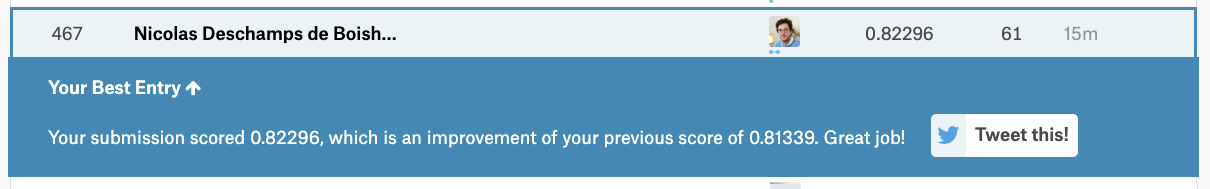

Et voilà !

## Conclusion

Predict some survived men seems to be the most complicated part and could be an improvement of this model.

Here I tried to let XGBoost do the work, after I fed it with features containing a lot of useful informations. Maybe some more complex interactions could help, but the most difficult part is giving new useful informations to the model without overfitting.

I hope this notebook helped some of you. I learned a lot by making it, so if you learn reading it, I'll be glad :) The key is really to read other top kernels and try your own stuffs. I spent a lot of time reading and trying!

If you have any suggestions / remarks / questions or anything else, please feel free to leave a comment.